In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Cargar los datos
df = pd.read_csv('datos.csv', encoding='latin1')

# Seleccionar aleatoriamente el 10% de los datos
df_sample = df.sample(frac=0.1, random_state=1)

# Convertir todas las columnas categóricas a numéricas
for column in df_sample.select_dtypes(include=['object']).columns:
    df_sample[column] = LabelEncoder().fit_transform(df_sample[column])

# Dividir datos en características (X) y etiquetas (y)
X = df_sample.drop('CONDICION_1', axis=1)  # Ajusta según tus características
y = df_sample['CONDICION_1']  # Ajusta según tus etiquetas

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(optimizer='adam', init='uniform'):
    model = Sequential()
    model.add(Dense(8, input_dim=X_train.shape[1], activation='relu', kernel_initializer=init))
    model.add(Dense(4, activation='relu', kernel_initializer=init))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
import random

def cuckoo_search(nests, pa=0.25, beta=1.5, n_iterations=10):
    def levy_flight(Lambda):
        sigma1 = (np.math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) /
                  (np.math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
        sigma2 = 1
        u = np.random.normal(0, sigma1, size=1)
        v = np.random.normal(0, sigma2, size=1)
        step = u / abs(v) ** (1 / Lambda)
        return step

    def get_fitness(nests):
        fitness = []
        for nest in nests:
            model = create_model(optimizer=nest['optimizer'], init=nest['init'])
            history = model.fit(X_train, y_train, epochs=3, batch_size=10, verbose=0)  # Reducir a 3 épocas
            _, accuracy = model.evaluate(X_test, y_test, verbose=0)
            fitness.append(accuracy)
        return fitness

    num_nests = len(nests)
    fitness = get_fitness(nests)
    best_nest = nests[np.argmax(fitness)]

    for _ in range(n_iterations):
        new_nests = []
        for nest in nests:
            step_size = levy_flight(beta)
            new_nest = {key: nest[key] for key in nest}
            new_nest['optimizer'] = np.random.choice(['adam', 'sgd'])
            new_nest['init'] = np.random.choice(['uniform', 'normal'])
            new_nests.append(new_nest)

        new_fitness = get_fitness(new_nests)
        for i in range(num_nests):
            if new_fitness[i] > fitness[i]:
                nests[i] = new_nests[i]
                fitness[i] = new_fitness[i]

        best_nest = nests[np.argmax(fitness)]
        # Abandono aleatorio
        for nest in nests:
            if random.uniform(0, 1) < pa:
                nest['optimizer'] = np.random.choice(['adam', 'sgd'])
                nest['init'] = np.random.choice(['uniform', 'normal'])

    return best_nest

# Inicializar nidos
nests = [{'optimizer': 'adam', 'init': 'uniform'} for _ in range(5)]

# Ejecutar la búsqueda Cuckoo
best_params = cuckoo_search(nests, n_iterations=10)

# Crear el modelo con los mejores parámetros encontrados
model = create_model(optimizer=best_params['optimizer'], init=best_params['init'])
model.fit(X_train, y_train, epochs=5, batch_size=10, verbose=1)

# Evaluar el modelo
_, accuracy = model.evaluate(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1334/1334 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0903 - loss: nan
Epoch 2/5
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0842 - loss: nan
Epoch 3/5
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0793 - loss: nan
Epoch 4/5
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0854 - loss: nan
Epoch 5/5
1334/1334 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0824 - loss: nan
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0777 - loss: nan
Accuracy: 7.98%


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, auc

# Obtener predicciones del modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Obtener el reporte de clasificación
report = classification_report(y_test, y_pred, output_dict=True)

# Extraer las métricas de interés
labels = list(report.keys())[:-3]
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision: [0.07978404319136173, 0.0, 0.0, 0.0]
Recall: [1.0, 0.0, 0.0, 0.0]
F1 Score: [0.14777777777777779, 0.0, 0.0, 0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Definir el modelo para KerasClassifier
def create_model_cv():
    model = Sequential()
    model.add(Dense(8, input_dim=X_train.shape[1], activation='relu', kernel_initializer=best_params['init']))
    model.add(Dense(4, activation='relu', kernel_initializer=best_params['init']))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=best_params['init']))
    model.compile(loss='binary_crossentropy', optimizer=best_params['optimizer'], metrics=['accuracy'])
    return model

# Envolver el modelo para usarlo en scikit-learn
model_cv = KerasClassifier(build_fn=create_model_cv, epochs=5, batch_size=10, verbose=0)

# Realizar validación cruzada
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
results = cross_val_score(model_cv, X, y, cv=kfold, scoring='accuracy')
print("Cross-Validation Accuracy: %.2f%%" % (results.mean()*100))

# Calcular otras métricas en la validación cruzada
for train_index, test_index in kfold.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

    model_cv.fit(X_train_cv, y_train_cv)
    y_pred_cv = model_cv.predict(X_test_cv)

    report_cv = classification_report(y_test_cv, y_pred_cv, output_dict=True)
    precision_cv = [report_cv[label]['precision'] for label in labels]
    recall_cv = [report_cv[label]['recall'] for label in labels]
    f1_score_cv = [report_cv[label]['f1-score'] for label in labels]
    print("CV Precision:", precision_cv)
    print("CV Recall:", recall_cv)
    print("CV F1 Score:", f1_score_cv)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using 

Cross-Validation Accuracy: 8.24%


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision

CV Precision: [0.08225341972642189, 0.0, 0.0, 0.0]
CV Recall: [1.0, 0.0, 0.0, 0.0]
CV F1 Score: [0.15200399135207052, 0.0, 0.0, 0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/scikeras/

CV Precision: [0.08243340532757379, 0.0, 0.0, 0.0]
CV Recall: [1.0, 0.0, 0.0, 0.0]
CV F1 Score: [0.15231127369471234, 0.0, 0.0, 0.0]
CV Precision: [0.08243340532757379, 0.0, 0.0, 0.0]
CV Recall: [1.0, 0.0, 0.0, 0.0]
CV F1 Score: [0.15231127369471234, 0.0, 0.0, 0.0]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


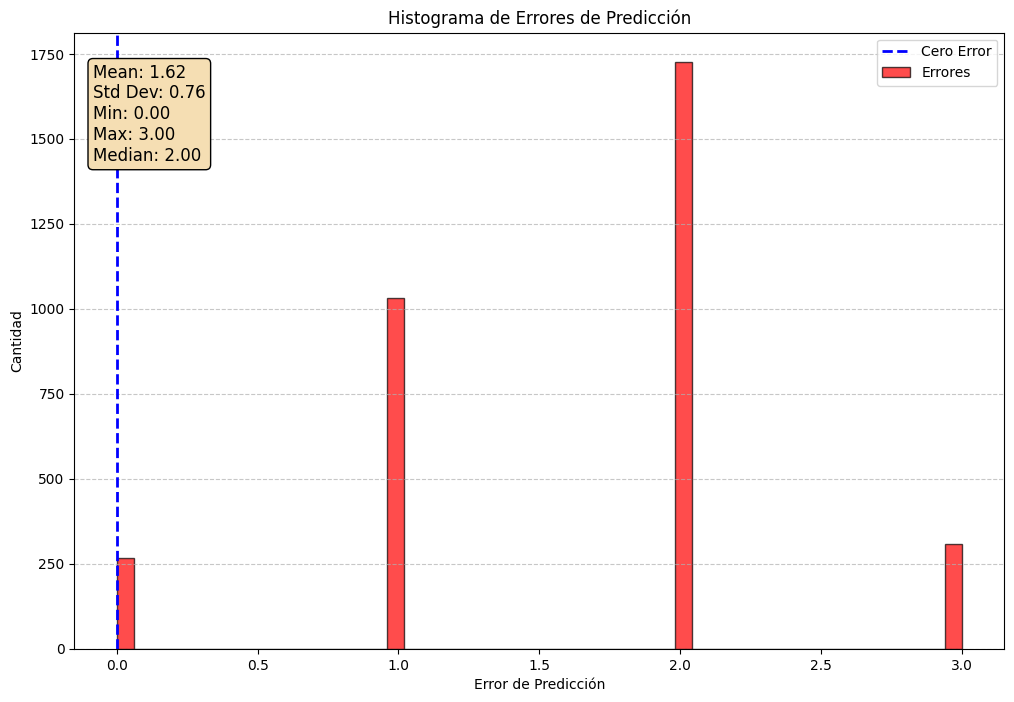

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular los errores de predicción
errors = y_test - y_pred.flatten()

# Configurar el histograma de errores
plt.figure(figsize=(12, 8))
n, bins, patches = plt.hist(errors, bins=50, color='red', alpha=0.7, edgecolor='black')

# Añadir una línea vertical en cero
plt.axvline(0, color='blue', linestyle='dashed', linewidth=2)

# Etiquetas y título
plt.xlabel('Error de Predicción')
plt.ylabel('Cantidad')
plt.title('Histograma de Errores de Predicción')

# Añadir una leyenda
plt.legend(['Cero Error', 'Errores'], loc='upper right')

# Añadir estadísticas descriptivas
mean_error = np.mean(errors)
std_error = np.std(errors)
min_error = np.min(errors)
max_error = np.max(errors)
median_error = np.median(errors)

# Añadir anotaciones de estadísticas
textstr = f'Mean: {mean_error:.2f}\nStd Dev: {std_error:.2f}\nMin: {min_error:.2f}\nMax: {max_error:.2f}\nMedian: {median_error:.2f}'
props = dict(boxstyle='round', facecolor='wheat')
plt.gca().text(0.02, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


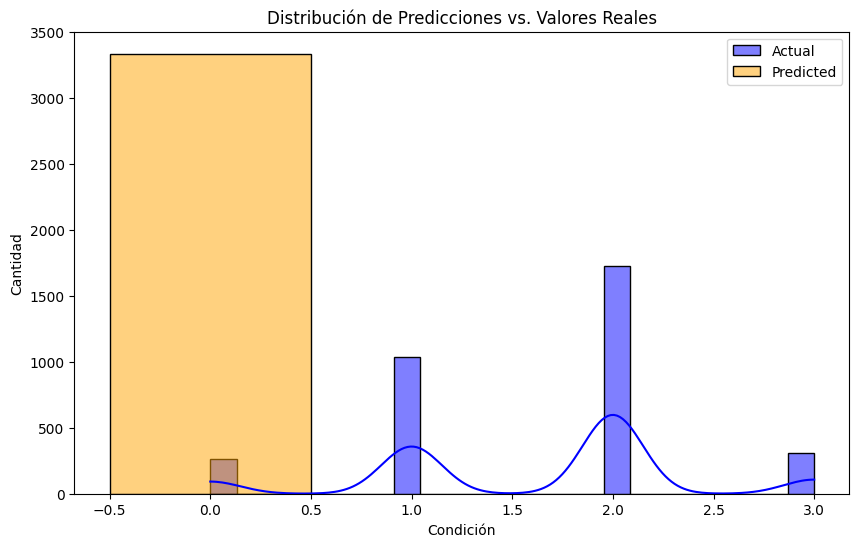

In [ ]:
# Comparación de las distribuciones de predicciones y valores reales
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', label='Actual', kde=True)
sns.histplot(y_pred.flatten(), color='orange', label='Predicted', kde=True)
plt.xlabel('Condición')
plt.ylabel('Cantidad')
plt.title('Distribución de Predicciones vs. Valores Reales')
plt.legend()
plt.show()


<Figure size 1200x800 with 0 Axes>

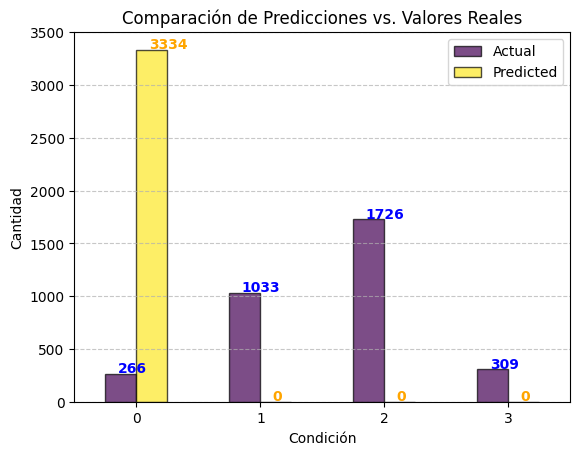

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comparación de predicciones
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred.flatten()})

# Crear una tabla de frecuencias para los valores reales y las predicciones
actual_counts = predictions['Actual'].value_counts().sort_index()
predicted_counts = predictions['Predicted'].value_counts().sort_index()

# Crear un DataFrame con las frecuencias para graficar
comparison_df = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts}).fillna(0)

# Configuración del gráfico
plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar', alpha=0.7, colormap='viridis', edgecolor='black')

# Etiquetas y título
plt.xlabel('Condición')
plt.ylabel('Cantidad')
plt.title('Comparación de Predicciones vs. Valores Reales')
plt.xticks(rotation=0)

# Anotaciones en las barras
for i in range(len(comparison_df)):
    plt.text(i - 0.15, comparison_df['Actual'].iloc[i] + 10, int(comparison_df['Actual'].iloc[i]), color='blue', fontweight='bold')
    plt.text(i + 0.1, comparison_df['Predicted'].iloc[i] + 10, int(comparison_df['Predicted'].iloc[i]), color='orange', fontweight='bold')

# Leyenda
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


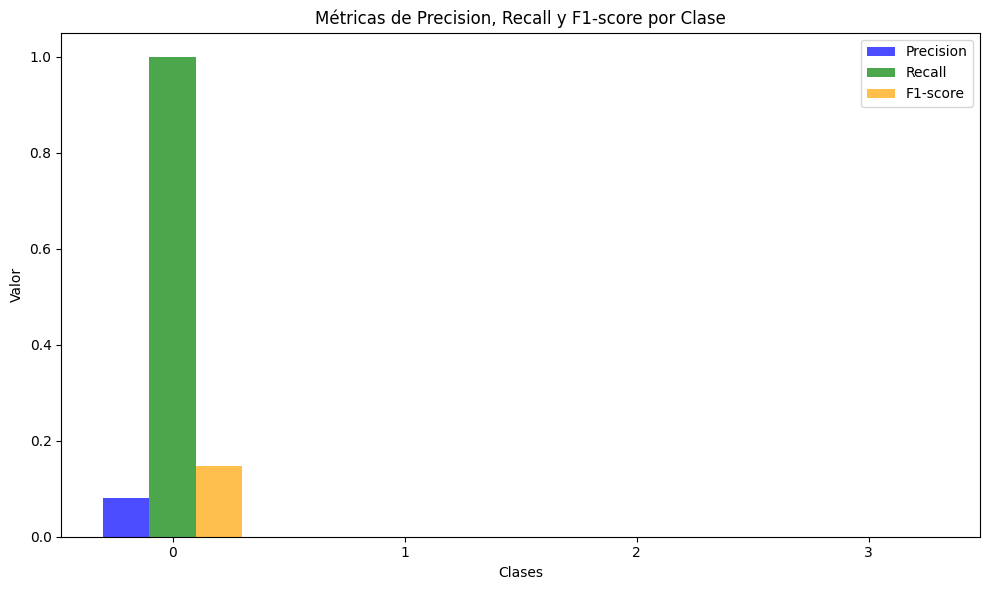

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Obtener el reporte de clasificación
report = classification_report(y_test, y_pred, output_dict=True)

# Extraer las métricas de interés
labels = list(report.keys())[:-3]
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1_score = [report[label]['f1-score'] for label in labels]

# Configurar el gráfico
plt.figure(figsize=(10, 6))

# Definir posiciones para las barras
x = range(len(labels))
width = 0.2

# Dibujar las barras
plt.bar(x, precision, width=width, label='Precision', color='blue', alpha=0.7)
plt.bar([i + width for i in x], recall, width=width, label='Recall', color='green', alpha=0.7)
plt.bar([i + 2 * width for i in x], f1_score, width=width, label='F1-score', color='orange', alpha=0.7)

# Etiquetas y título
plt.xlabel('Clases')
plt.ylabel('Valor')
plt.title('Métricas de Precision, Recall y F1-score por Clase')
plt.xticks([i + width for i in x], labels)
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()
